In [1]:
import matplotlib.pyplot as plt
import numpy as np
import quadpy

%config InlineBackend.figure_format = "retina"

#### Kelvin point source solution

In [2]:
def kelvin_point_source(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    kelvin_displacements = np.zeros((len(x), 2))
    kelvin_stresses = np.zeros((len(x), 3))
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    kelvin_displacements[:, 0] = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (
        2 * mu
    ) * (-y * gx)
    kelvin_displacements[:, 1] = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * (
        (3 - 4 * nu) * g - y * gy
    )
    kelvin_stresses[:, 0] = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (
        2 * nu * gy - y * gxx
    )
    kelvin_stresses[:, 1] = fx * (2 * nu * gx - x * gyy) + fy * (
        2 * (1 - nu) * gy - y * gyy
    )
    kelvin_stresses[:, 2] = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * (
        (1 - 2 * nu) * gx - y * gxy
    )
    return kelvin_displacements, kelvin_stresses

#### `quadpy` integration
Great news! The integration works very well OUTSIDE the source domain. It is dominated by singularities inside the source - use scipy.dblquad() instead.

In [3]:
triangle = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
scheme = quadpy.t2.get_good_scheme(20)
points_new = np.dot(triangle.T, scheme.points)
n_integration_pts = len(scheme.weights)

In [4]:
x_offset = 0.0
y_offset = 0.0
fx = -1.0
fy = 0.0
mu = 1.0
nu = 0.25
n_obs = 100
x_vec = np.linspace(0, 1, n_obs)
y_vec = np.linspace(0, 1, n_obs)
x_grid, y_grid = np.meshgrid(x_vec, y_vec)

kelvin_displacements = np.zeros((n_obs**2, 2))
kelvin_stresses = np.zeros((n_obs**2, 3))

for i in range(n_integration_pts):
    x_offset = points_new[0, i]
    y_offset = points_new[1, i]
    kelvin_displacements_local, kelvin_stresses_local = kelvin_point_source(
        x_grid.flatten(), y_grid.flatten(), x_offset, y_offset, fx, fy, mu, nu
    )
    kelvin_displacements += scheme.weights[i] * kelvin_displacements_local
    kelvin_stresses += scheme.weights[i] * kelvin_stresses_local

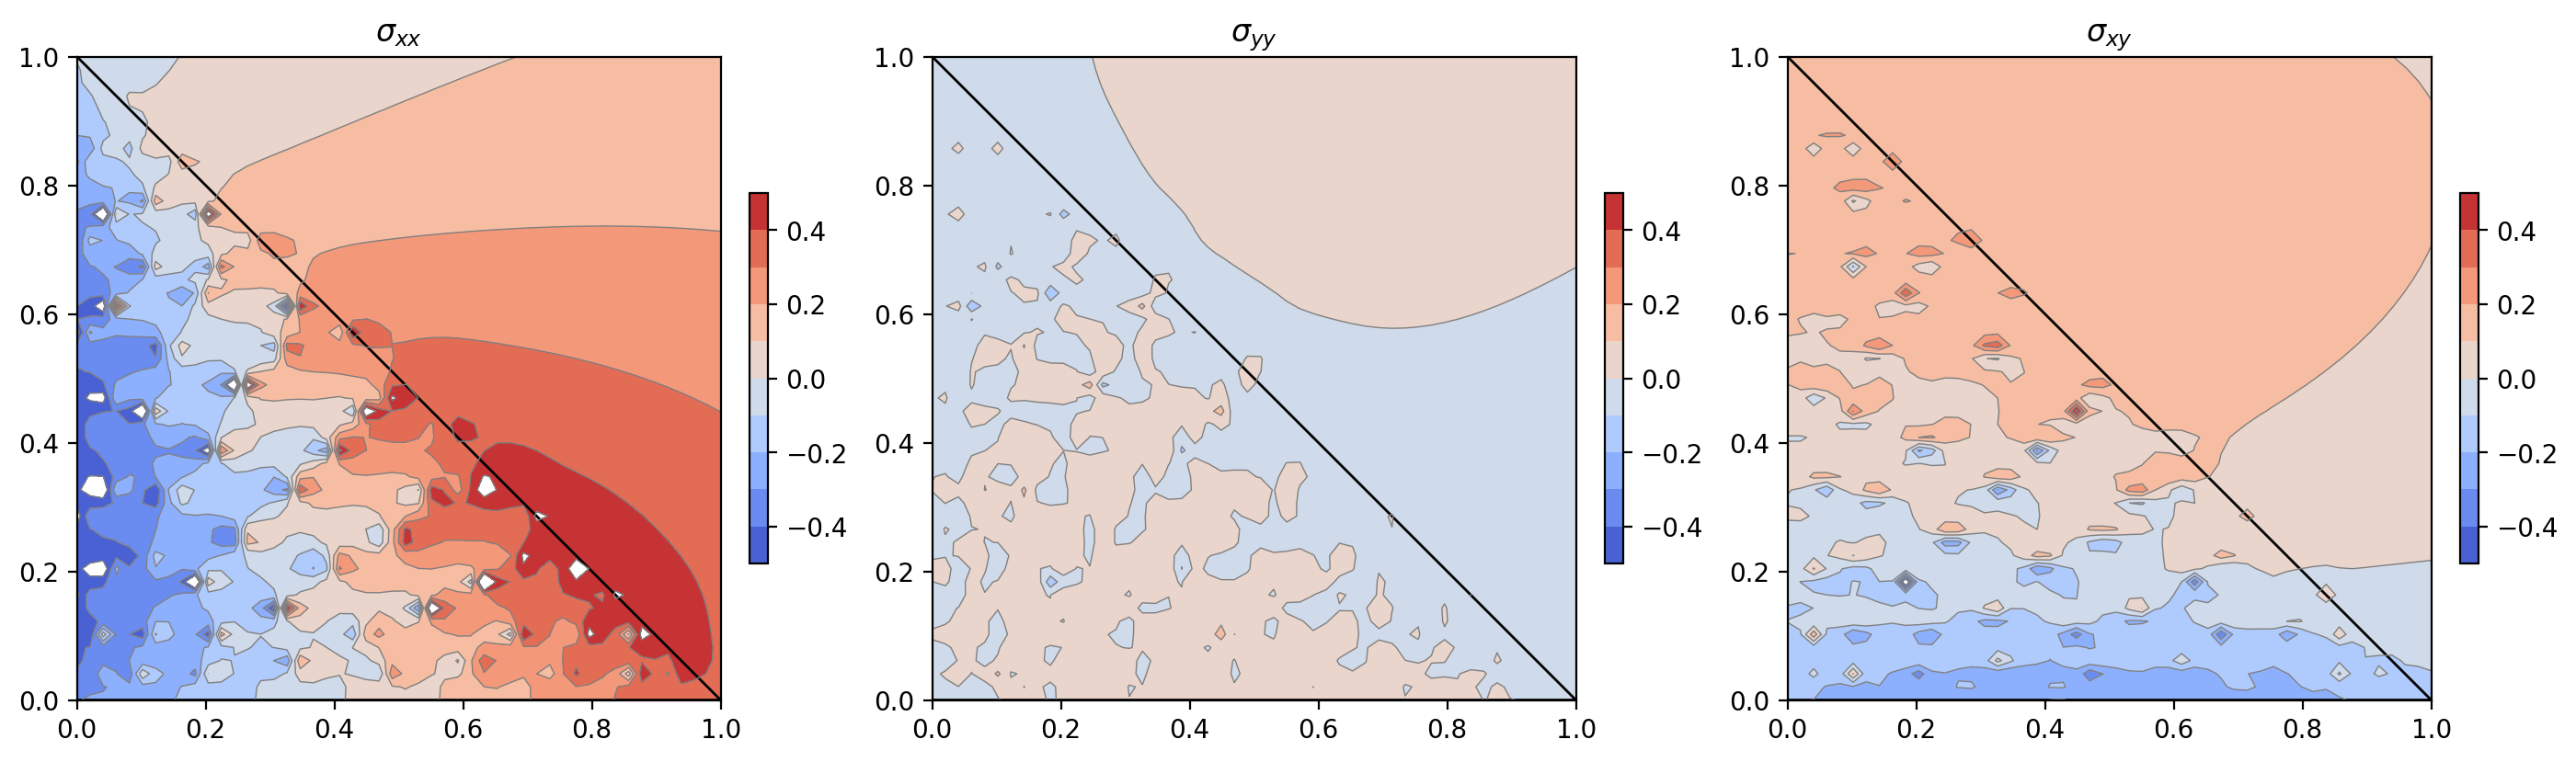

In [5]:
LINEWIDTH = 0.5
LEVELS = np.linspace(-0.5, 0.5, 11)

plt.figure(figsize=(17, 10))


def plot_stresses(x_grid, y_grid, stresses, triangle, title_string):
    plt.contourf(
        x_grid,
        y_grid,
        stresses,
        cmap="coolwarm",
        levels=LEVELS,
    )
    plt.colorbar(fraction=0.026, pad=0.04, extend="both")
    plt.clim([-0.5, 0.5])
    plt.contour(
        x_grid,
        y_grid,
        stresses,
        colors="gray",
        linestyles="solid",
        linewidths=LINEWIDTH,
        levels=LEVELS,
    )
    plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
    plt.title(title_string)
    plt.gca().set_aspect("equal")
    plt.xlim([np.min(triangle[:, 0]), np.max(triangle[:, 0])])
    plt.ylim([np.min(triangle[:, 1]), np.max(triangle[:, 1])])


plt.subplot(2, 3, 4)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(kelvin_stresses[:, 0], (n_obs, n_obs)),
    triangle,
    "$\sigma_{xx}$",
)

plt.subplot(2, 3, 5)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(kelvin_stresses[:, 1], (n_obs, n_obs)),
    triangle,
    "$\sigma_{yy}$",
)

plt.subplot(2, 3, 6)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(kelvin_stresses[:, 2], (n_obs, n_obs)),
    triangle,
    "$\sigma_{xy}$",
)

plt.show()